# 最適化手法の紹介

### アジェンダ
* 確立的勾配法(SGD : stochastic gradient descent)
* Momentum
* AdaGrad
* Adam

### 参考サイト
[サイボウズ・ラボ](https://www.slideshare.net/nishio/ss-66840545)  
[等高線の描画](http://ailaby.com/contour/)  
[数式のマークダウン記法](https://qiita.com/PlanetMeron/items/63ac58898541cbe81ada#%E5%88%86%E6%95%B0)

# SGDとは

1. 現在位置 $x_i$ での勾配 $g(x_i)$ を計算
2. その勾配に学習率 $lr$ を掛けたもので位置を更新

$$ x_{i+1} = x_i - lr*g(x_i)$$

In [2]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
        return params

# SGDの欠点

次の関数を考えます。
$$f(x,y) = \frac{1}{20}x^2 + y^2$$
この関数の勾配をプロットすると、下図のようになります。

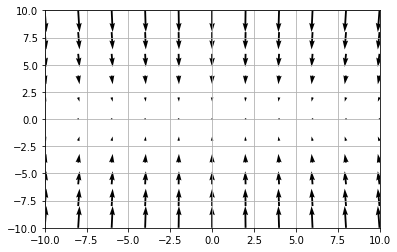

In [3]:
# 関数のプロット
# 必要なモジュールのインポート
import numpy as np
import matplotlib.pyplot as plt

# 新規ウインドウの作成
plt.figure()

# ベクトルの作成
x = np.arange(-10,12,2)
y = np.arange(-10,12,2)

# 描画のためのx,yメッシュを作成
X, Y = np.meshgrid(x,y)

# ベクトルの描画
plt.quiver(X,Y,-X/10, -Y*2, angles='xy', scale_units='xy', scale=10)

# x,y軸の範囲設定
plt.xlim([-10,10])
plt.ylim([-10,10])

# グラフ描画
plt.grid()
plt.draw()
plt.show()

真の最小値は(0,0)になりますが、ほとんどの点でその方向を向いていないことが分かります。  

SGDによる探索経路は下図のようになります。

In [4]:
# 等高線作成用の関数
def same_height():
    ## ベクトルの作成
    x = np.arange(-10,10,0.01)
    y = np.arange(-6,6,0.1)

    # 描画のためのx,yメッシュを作成
    X, Y = np.meshgrid(x,y)

    # 関数の計算
    Z = (X**2)/20 + Y**2
    
    return X,Y,Z

In [5]:
# 関数の作成
def function(x):
    return x[0]**2/20 + x[1]**2

# 数値微分を行う関数
def numerical_gradient(f, x, y, h = 1e-4):
    grad = np.zeros(2)
    t = []
    t.append(x)
    t.append(y)
    t = np.array(t)
    
    for idx in range(t.size):
        tmp_val = t[idx]
        # f(x+h)の計算
        t[idx] = tmp_val + h
        fxh1 = f(t)
        
        # f(x-h)の計算
        t[idx] = tmp_val - h
        fxh2 = f(t)
        
        grad[idx] = (fxh1 - fxh2) / h
        t[idx] = tmp_val
        
    return grad

# 描画を行う関数
def plot_learn(update_type,lr,n, x, y):
    # classの呼び出し
    if update_type == "SGD":
        use_class = SGD(lr)
    elif update_type == "Momentum":
        use_class = Momentum(lr)
    elif update_type == "AdaGrad":
        use_class = AdaGrad(lr)
    else:
        use_class = Adam(lr)

    # 等高線の描画
    X,Y,Z = same_height()
    plt.contour(X,Y,Z)

    # 探索経路の描画
    params = {}
    params['x'] = x
    params['y'] = y
    grads = {}
    record_x = []
    record_y = []
    record_x.append(params['x'])
    record_y.append(params['y'])

    for i in range(n):
        grad = numerical_gradient(function, params['x'],params['y'])
        grads['x'] = grad[0]
        grads['y'] = grad[1]
        params = use_class.update(params,grads)
        record_x.append(params['x'])
        record_y.append(params['y'])

    plt.plot(record_x, record_y)
    plt.show()

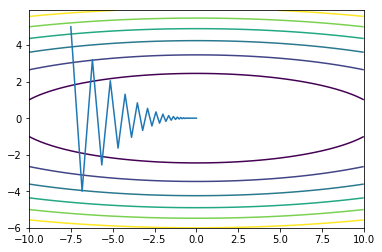

In [8]:
# SGDによる探索経路のプロット
plot_learn("SGD",0.45,100,-7.5,5)

学習率 $lr$ にもよるが、ギザギザに動き、無駄が多いことが分かる。

# Momentumとは

### idea 「慣性をつけたらいいんじゃないか！？」
1.  現在位置 $x_i$ での勾配 $g(x_i)$ に学習率を掛ける
2. 前回の更新量に0.9ぐらいの減衰率 $\gamma$ を掛ける
3. 両方を使って位置を更新
$$ x_{i+1} = x_i + \gamma  (x_i - x_{i-1}) - lr * g(x_i)$$

In [10]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key]  =self.momentum * self.v[key] - self.lr * grads[key] # (1)
            params[key] += self.v[key] #(2)
            
        return params
    

### (*1)について 
まず
$$ \alpha_i = \gamma (x_i - x_{i-1}) - lr*g(x_i)$$
と定義すると、Momentumの基本式より
$$ x_{i+1} - x_i = \gamma (x_i - x_{i-1}) - lr*g(x_i) =\alpha_{i+1}$$
となる。

よって、Momentumの基本式は次のように書き換えられる。
$$ x_{i+1} = x_i + \gamma*\alpha_i - lr * g(x_i)$$

よって、(1)は、
$$ v = \gamma*\alpha_i - lr * g(x_i)$$
を計算していることになり、
(2)は
$$ x_{i+1} = x_i + v$$
を計算していることになる。

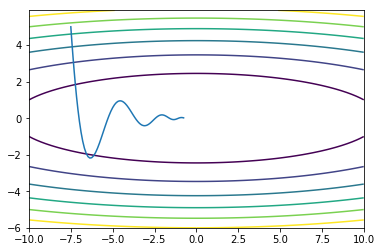

In [17]:
# Momentumによる探索経路のプロット
plot_learn("Momentum",0.01,100,-7.5,5)

学習率にもよるが、SGDよりもジグザグ度合いが減少していることが分かる。

# AdaGradとは

### 1. 学習係数(数式では$ \mu$)はニューラルネットワークにおいて非常に重要  
→　小さすぎると学習に時間がかかり過ぎてしまい、大きすぎると発散して正しく学習が行えない
### 2. 学習係数の減衰を行う  
→最初は”大きく”学習し、次第に"小さく"学習する
### 3. このアイデアはパラメータ「全体」の学習係数の値を一括して下げることに相当する  
→「1つ1つ」のパラメータに対して学習係数を調整する

$$\displaystyle\boldsymbol{h} \leftarrow \displaystyle\boldsymbol{h} + \frac{\partial L}{\partial  \displaystyle\boldsymbol{W}}
.*\frac{\partial L}{\partial  \displaystyle\boldsymbol{W}}$$

$$\displaystyle\boldsymbol{W} \leftarrow \displaystyle\boldsymbol{W} - \mu \frac{1}{\sqrt{\displaystyle\boldsymbol{h}}}\frac{\partial L}{\partial  \displaystyle\boldsymbol{W}}$$

### 4. 学習係数の初期値が他の方法とは異なる  
→他の方法の１０倍程度に設定する

In [18]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] = self.h[key] + grads[key] * grads[key]
            params[key] = params[key] - self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
        return params

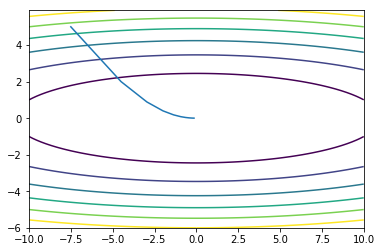

In [24]:
# AdaGradによる探索経路のプロット
plot_learn("AdaGrad",3,10,-7.5,5)

Momentumよりも少ない更新回数で収束していることが分かる。

# Adamとは

1. MomentumとAdaGradを合わせたような方法

In [25]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.m[key] + (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] = self.v[key] +  (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] = params[key] - lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
        
        return params

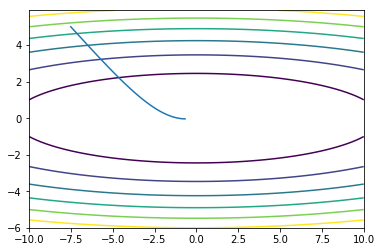

In [30]:
# Adamによる探索経路のプロット
plot_learn("Adam",0.1,100,-7.5,5)

AdaGradとほとんど同じだが、更新回数が多い

# 各更新手法の比較

SGD：学習係数 0.45 , 更新回数 100


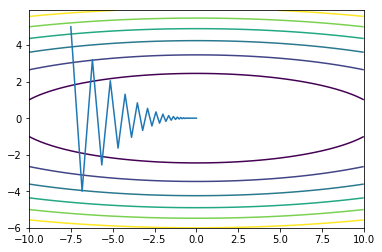

Momentum：学習係数 0.01 , 更新回数 100


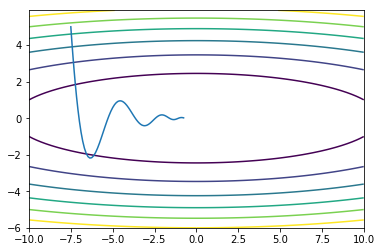

AdaGrad：学習係数 3 , 更新回数 10


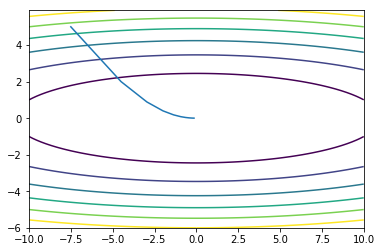

Adam：学習係数 0.1 , 更新回数 100


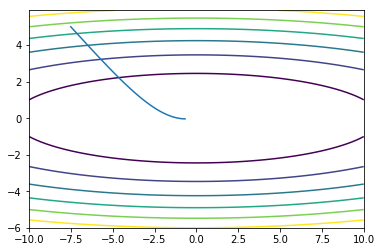

In [36]:
print("SGD：学習係数 0.45 , 更新回数 100")
plot_learn("SGD",0.45,100,-7.5,5)
print("Momentum：学習係数 0.01 , 更新回数 100")
plot_learn("Momentum",0.01,100,-7.5,5)
print("AdaGrad：学習係数 3 , 更新回数 10")
plot_learn("AdaGrad",3,10,-7.5,5)
print("Adam：学習係数 0.1 , 更新回数 100")
plot_learn("Adam",0.1,100,-7.5,5)

<img src="optimizer_compare.png=200x200">

<img src="optimizer_compare.png" width="400px" height="400px"　style="float:left">

<img src="optimizer_compare.png = 200x200">